**First things first** - please go to 'File' and select 'Save a copy in Drive' so that you have your own version of this activity set up and ready to use.
Remember to update the portfolio index link to your own work once completed!

# Activity 7.3.3 Performing ARIMA models in Python

## Scenario
The Baltimore Police Department (BPD), situated in Baltimore, USA, created a data set containing crime records from 1 January 2011 to 18 June 2016. Although the data set is considered preliminary and subject to change, it contains 264,496 rows and 11 columns (BPD, 2024).

For this activity, the data set was adapted to indicate the number of daily crime incidents from 1 January 2011 to 31 December 2015. Therefore, the data set contains 2,143 rows and two columns. You are tasked to analyse the provided data set to forecast future crime predictions. You must also provide a clear and precise rationale for your analysis and findings.


## Objective
In this portfolio activity, you’ll use ARIMA models to forecast crimes.

You will complete the activity in your Notebook, where you’ll:
- load and prepare data
- verify seasonality with ACF
- define and fit five SARIMA models
- forecast next 52 weeks
- fit training set with Auto ARIMA
- identify best model using MSE.



## Assessment criteria
By completing this activity, you will be able to provide evidence that you can:
- Synthesise autocorrelation and stationarity concepts and define their importance in time series analysis.
- Recognise white noise, identify random walk behaviour processes in time series, and apply statistical tests for model diagnostics.
- Accurately perform time series decomposition, including seasonality, trend, and residual components, and apply transformations to make time series stationary.
- Critically evaluate the effectiveness of time series analysis to address real-world problems.



## Activity guidance

1. Run the following commands to load and shape data:


```
     crime = pd.read_csv('../python_files/BPD_Part_1_Victim_Based_Crime_Data_dailyIncidents_activity.csv')
     crime['date'] = pd.to_datetime(crime['date'])
     crime.set_index('date', inplace=True)
     crime.asfreq('d')
     crime.sort_index(inplace=True)
     crime['Incidents_imputed_spline'] = crime.Incidents.interpolate(method='spline', order=3)
     crime_weekly = crime.groupby(pd.Grouper(freq='w')).aggregate(np.mean)
     ts = crime_weekly.Incidents_imputed_spline
```


2. Split the data into two parts: A training set 'ts_train', and a test set 'ts_test',
   the latter containing the 52 last observations.
3. Verify (usning the ACF) that the seasonal period of ts_train is 52.
4. Define the five following SARIMA models in the form of a python list of order combinations [(p, d, q), (P, D, Q, m)]:


```
   SARIMA(1, 0, 0)(1, 1, 0, 52)
   SARIMA(0, 0, 1)(0, 1, 0, 52)
   SARIMA(0, 0, 0)(0, 1, 1, 52)
   SARIMA(0, 1, 1)(1, 1, 0, 52)
   SARIMA(1, 0, 1)(1, 1, 1, 52)
```


5. Fit the above five models and store the resulting model fits.
6. Create the 52 next model forecasts (with 95% CI's) from all five models corresponding to the 52 test set values.
   Plot separately for each model: ts_train, ts_test, forecast, 95% CI.
7. Calculate the Mean Squared Error for each model between ts_test and forecasted values.
   Which is the preferred model according to the above MSE's?
8. Fit the training set ts_train using the Auto ARIMA function with all default parameters and
   0 <= p <= 2, 0 <= q <= 2, d=0, 0 <= P <= 1, 0 <= Q <= 1, D=1, m=52,
   What is the resulting model?
9. Calculate again the next 52 time steps forecasts corresponding to the test set ts_test, along with a 95% CI.
   Plot ts_train, ts_test, forecast, and 95% CI.
10. Calculate the MSE between ts_test and AutoARIMA forecast. Is it better than the best fromthe five models above?

In [147]:
!pip install --upgrade --force-reinstall pmdarima numpy==1.24.0

  Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl.metadata (7.8 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 5.0 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of scipy to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 62.8 MB/s eta 0:00:00
Using cached pmdarima-2.0.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.manylinux_2_28_x86_64.whl (2.2 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.7/307.7 kB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.5/66.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB

In [27]:
import pandas as pd
import numpy as np
import statsmodels.graphics.api as smgraphics # gives access to all plotting functions in statsmodels.
import matplotlib.pyplot as plt
import warnings

from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from pmdarima.arima import auto_arima
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf

#surpress future warnings
warnings.filterwarnings("ignore", category=FutureWarning)

In [2]:
#load the data
crime = pd.read_csv('https://raw.githubusercontent.com/fourthrevlxd/cam_dsb/main/crime_incidents.csv')

In [3]:
#convert to datetime
crime['date'] = pd.to_datetime(crime['date'],errors='coerce')

/tmp/ipython-input-3-3788462645.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  crime['date'] = pd.to_datetime(crime['date'],errors='coerce')


In [4]:
#set date as index to indicate time series
crime.set_index('date', inplace=True)

In [5]:
#set frequency as day to impute any missing days
crime.asfreq('d')
#sort in time order
crime.sort_index(inplace=True)

In [6]:
#impute missing values using spline method of order 3
crime['Incidents_imputed_spline'] = crime.incidents.interpolate(method='spline', order=3)

In [7]:
#get average number of incidents per week
crime_weekly = crime.groupby(pd.Grouper(freq='w')).aggregate(np.mean)
ts = crime_weekly.Incidents_imputed_spline

In [8]:
#view data
print(ts.shape)
ts.head()

(307,)


,Incidents_imputed_spline
date,
2011-01-02,143.500000
2011-01-09,115.857143
2011-01-16,111.541073
2011-01-23,116.428571
2011-01-30,102.680699


In [9]:
ts.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 307 entries, 2011-01-02 to 2016-11-13
Freq: W-SUN
Series name: Incidents_imputed_spline
Non-Null Count  Dtype  
--------------  -----  
307 non-null    float64
dtypes: float64(1)
memory usage: 4.8 KB


Text(0, 0.5, 'Incidents')

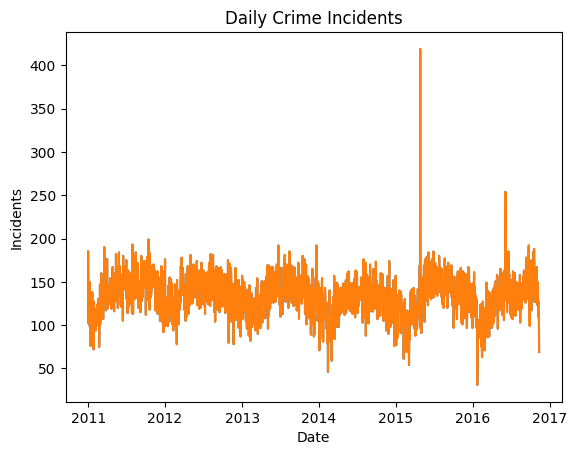

In [10]:
#plot raw data
plt.plot(crime)
plt.title('Daily Crime Incidents')
plt.xlabel('Date')
plt.ylabel('Incidents')

Text(0, 0.5, 'Incidents')

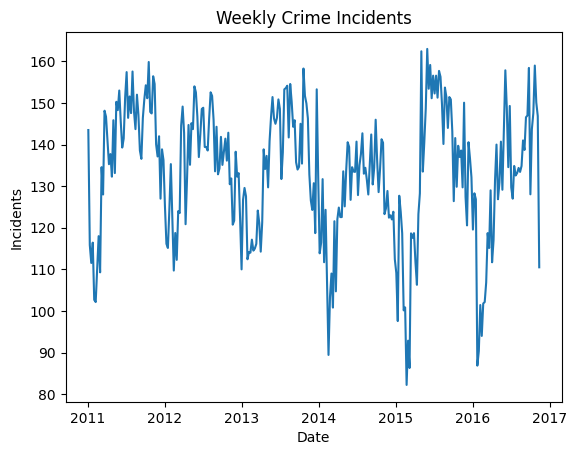

In [11]:
#plot raw data
plt.plot(ts)
plt.title('Weekly Crime Incidents')
plt.xlabel('Date')
plt.ylabel('Incidents')

In [12]:
#set last 52 weeks as test data (year)
ts_test = ts[-52:]
#get all but last 52 weeks as training data
ts_train = ts[:-52]

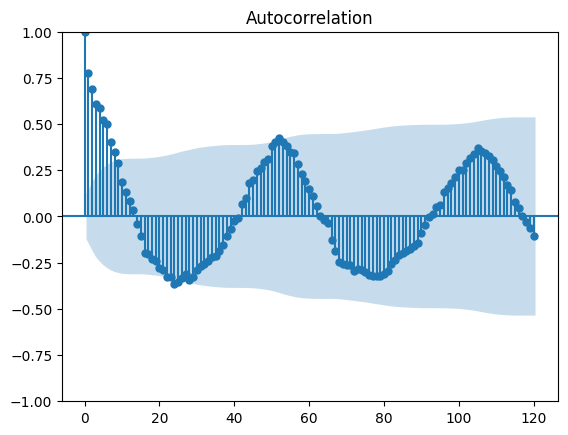

In [13]:
smgraphics.tsa.plot_acf(ts_train,lags=120);

In [28]:
#observe the exact acf values at each lag to determine the exact lag it peaks
acf_vals = acf(ts_train, nlags=60)
lags = np.arange(len(acf_vals))
for i in np.arange(len(acf_vals)):
  print(i, acf_vals[i])

0 1.0
1 0.7759212724735478
2 0.6922820910337932
3 0.6083337852264389
4 0.5880127023073896
5 0.5234576397482114
6 0.49840262410224134
7 0.40360874789089635
8 0.34640478623784327
9 0.2910395354420869
10 0.18924792652167075
11 0.13198579272030558
12 0.08472023541451087
13 0.036808622968107385
14 -0.041780409209537746
15 -0.10765829257152801
16 -0.19624554806876565
17 -0.2038796262450832
18 -0.22768075150319744
19 -0.2385690260720693
20 -0.276322283223513
21 -0.291251841361092
22 -0.325478722966851
23 -0.32676954151617377
24 -0.3636241485928147
25 -0.35367426581201794
26 -0.3331920904235737
27 -0.31235035882713974
28 -0.34161043006011
29 -0.32946724150273454
30 -0.28911587862881644
31 -0.2658984556497425
32 -0.2559934397490651
33 -0.2416278797361848
34 -0.22055240670095025
35 -0.21241865037026558
36 -0.18751069681764176
37 -0.15477870103462477
38 -0.10368183702483648
39 -0.06815184759168795
40 -0.023863323921861846
41 -0.009867712025630646
42 0.06493297617694813
43 0.10256495424599948
44 0

Given that this dataset is showing yearly data and is grouped by weeks the seasonal period is likely to be 52. This can be seen from the ACF plot which shows repreating patterns around lag 52 and 104. This is confirmed by looking at the exact acf numbers which peak at lag 52.

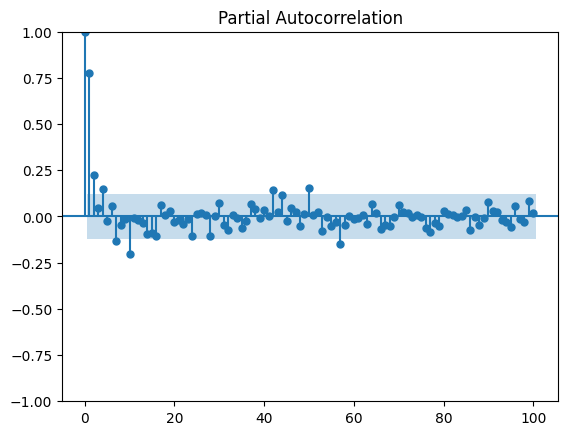

In [24]:
#plot PACF
smgraphics.tsa.plot_pacf(ts_train,lags=100);

In [25]:
#test for stationary using ADF test
adf_result = adfuller(ts_train.dropna())
print('p-value weekly data:', adf_result[1])

p-value weekly data: 0.0009540222591156558


If the p-value is less than 0.05 we reject the null hypothesis and can conclude the time series is stationary, otherwise we fail to reject the null hypothesis. Therefore, given the results we can conclude it is stationary, we therefore do not need to difference the data.

In [14]:
#define orders for sarima models
order1 = [(1,0,0),(1,1,0,52)]
order2 = [(0,0,1),(0,1,0,52)]
order3 = [(0,0,0),(0,1,1,52)]
order4 = [(0,1,1),(1,1,1,52)]

In [32]:
#define function for easy use
def sarima_model(ds,order):
    model = SARIMAX(ds, order=order[0],seasonal_order=order[1],
                    enforce_stationarity=False)
    #fit the model
    sarima = model.fit(maxiter=500,disp=False)
    #results
    sarima_summary = sarima.summary()
    #forecast next 52 steps
    forecast = sarima.get_forecast(steps=52)
    #get 95% confidence intervales
    xhat_conf_int = forecast.conf_int(alpha=0.05)
    #predicted values
    xhat = forecast.predicted_mean
    #calculate the mean squared error
    mse = mean_squared_error(ts_test,xhat)
    return sarima, xhat, xhat_conf_int,order,mse, sarima_summary

In [33]:
#fit all the models
sarima1 = sarima_model(ts_train,order1)
sarima2 = sarima_model(ts_train,order2)
sarima3 = sarima_model(ts_train,order3)
sarima4 = sarima_model(ts_train,order4)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [17]:
def plot_sarima(sarima):
    #plot the fitted values
    plt.figure(figsize=(14,6))
    plt.plot(ts_train, label = 'Observed')
    plt.plot(ts_test,label='Test Set')
    plt.plot(sarima[0].fittedvalues,label='Fitted Values')
    plt.plot(sarima[1],label='Forecast')
    plt.title(f'Weekly Crime Incidents in Baltimore - SARIMA{sarima[3]}')
    plt.legend()

    #plot the confidence intervals
    plt.plot(sarima[2], color='grey',linestyle='--',label='Confidence Interval')
    plt.legend(loc='lower right')

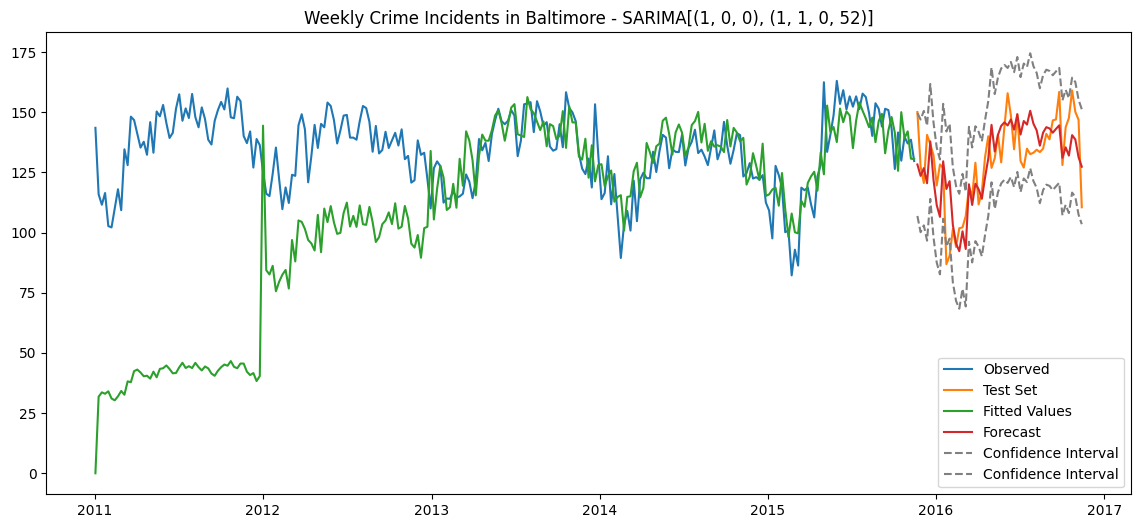

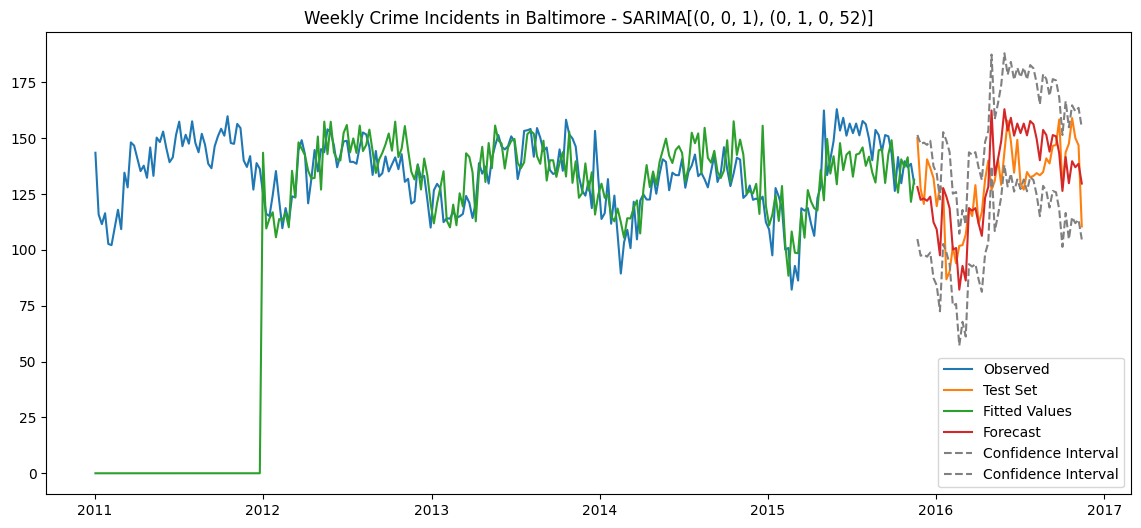

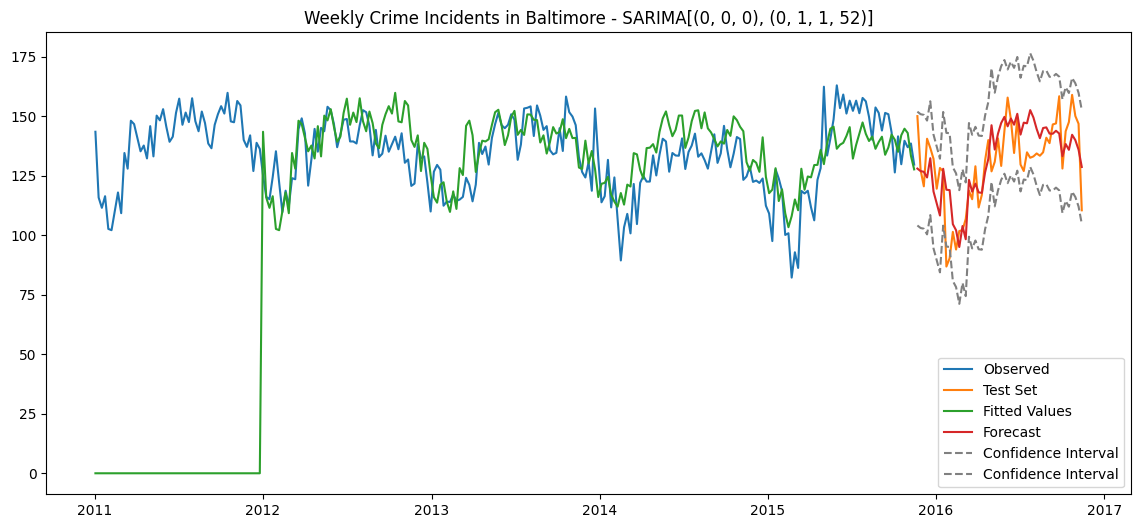

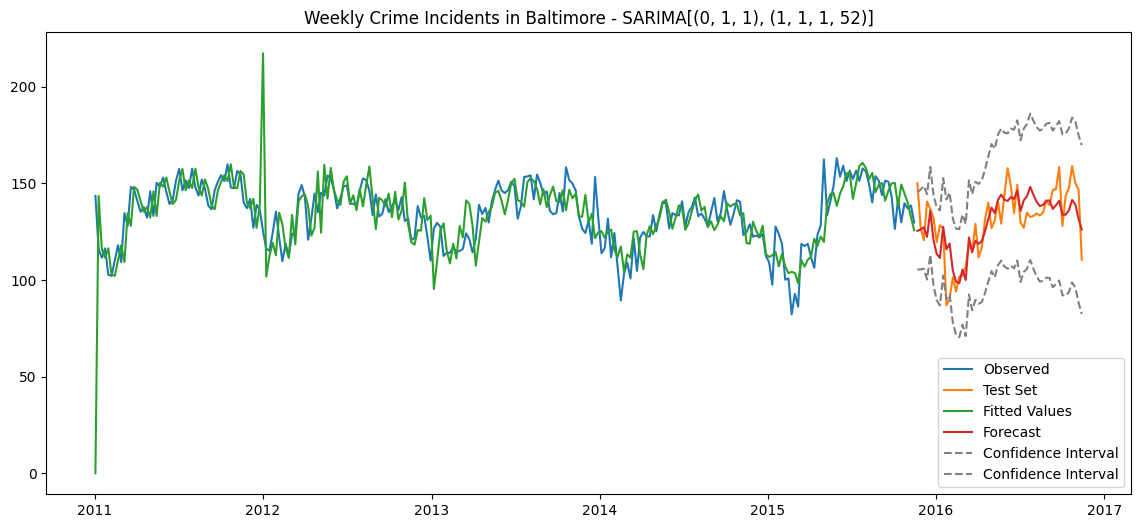

In [18]:
#plot sarima models
plot_sarima(sarima1)
plot_sarima(sarima2)
plot_sarima(sarima3)
plot_sarima(sarima4)

In [19]:
print(f'SARIMA{sarima1[3]} MSE: {sarima1[4]}')
print(f'SARIMA{sarima2[3]} MSE: {sarima2[4]}')
print(f'SARIMA{sarima3[3]} MSE: {sarima3[4]}')
print(f'SARIMA{sarima4[3]} MSE: {sarima4[4]}')

SARIMA[(1, 0, 0), (1, 1, 0, 52)] MSE: 147.73577508839975
SARIMA[(0, 0, 1), (0, 1, 0, 52)] MSE: 262.48122854873543
SARIMA[(0, 0, 0), (0, 1, 1, 52)] MSE: 148.99054745448478
SARIMA[(0, 1, 1), (1, 1, 1, 52)] MSE: 126.8445562661154


Given the mean squared errors above, the preferred model is the sarima 4 - SARIMA(0,1,1)(1,1,1,52). This means the current value of the time series is not dependent on past values, it needs to be differenced once to achieve stationarity, and the previous error term is needed to account for the current value.

For the seasonality component, the seasonal AR order is 1, suggesting the value depends on its own value one season ago, it must be differenced once to achieve stationarity, and the model uses order 1 to correct past seasonal forecasts, over a period of 52 to represent the yearly data.

In [22]:
#fit an auto arima model with criteria given in instructions
model = auto_arima(y=ts_train,X=None,
                   start_p=0, max_p=2,start_q=0, max_q=2,d=0,
                   start_P=0, max_P=1,start_Q=0, max_Q=1,D=1,m=52,
                   information_criterion='aic', seasonal=True, alpha=0.05,
                   stepwise=True, with_intercept='auto')

In [29]:
#print results
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  255
Model:             SARIMAX(1, 0, 2)x(1, 1, [], 52)   Log Likelihood                -764.160
Date:                             Sat, 26 Jul 2025   AIC                           1538.320
Time:                                     11:16:52   BIC                           1554.886
Sample:                                 01-02-2011   HQIC                          1545.022
                                      - 11-15-2015                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9403      0.048     19.493      0.000       0.846       1.035
ma.L1         -0.6006      0.084     -7.144      0.000      -0.765      -0.436
ma.L2         -0.1534      0.085     -1.798      0.072      -0.321       0.014
ar.S.L52      -0.3864      0.076     -5.071      0.000      -0.536      -0.237
sigma2       104.2926      8.863     11.767      0.000      86.921     121.664
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                25.24
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                             0.55
Prob(H) (two-sided):                  0.36   Kurtosis:                         4.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [34]:
#print the results of the original sarima model
sarima4[5]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:           Incidents_imputed_spline   No. Observations:                  255
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 52)   Log Likelihood                -557.452
Date:                            Sat, 26 Jul 2025   AIC                           1122.903
Time:                                    11:19:58   BIC                           1134.892
Sample:                                01-02-2011   HQIC                          1127.774
                                     - 11-15-2015                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7268      0.060    -12.118      0.000      -0.844      -0.609
ar.S.L52      -0.3063      0.134     -2.291      0.022      -0.568      -0.044
ma.S.L52      -0.3949      0.210     -1.882      0.060      -0.806       0.016
sigma2       103.2751     10.497      9.838      0.000      82.701     123.850
===================================================================================
Ljung-Box (L1) (Q):                   1.53   Jarque-Bera (JB):                23.91
Prob(Q):                              0.22   Prob(JB):                         0.00
Heteroskedasticity (H):               1.35   Skew:                             0.40
Prob(H) (two-sided):                  0.30   Kurtosis:                         4.80
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Auto arima suggests a different optimal order. Where the current value is dependent on the previous value, no differencing is recquired, and the error term is dependent on the previous 2 values. Seasonality component is the same, except it suggests no dependency in the error term.

The original SARIMA model has a lower AIC value suggesting it is a better fit overall than the model using auto-arima. However, the original sarima model has a higher ljung box value, this suggests that there is still autocorrelation left in the time series, indicating that the residuals do not resemble white noise and there is still unexplained variance in the model. Autoarima has a much lower value suggesting it is better at removing autocorrelation.

In [39]:
#calculate the next 52 time setps using provided model
aa_predictions = model.predict(n_periods=52, return_conf_int=True, alpha=0.05)
aa_fitted_values = model.fittedvalues()

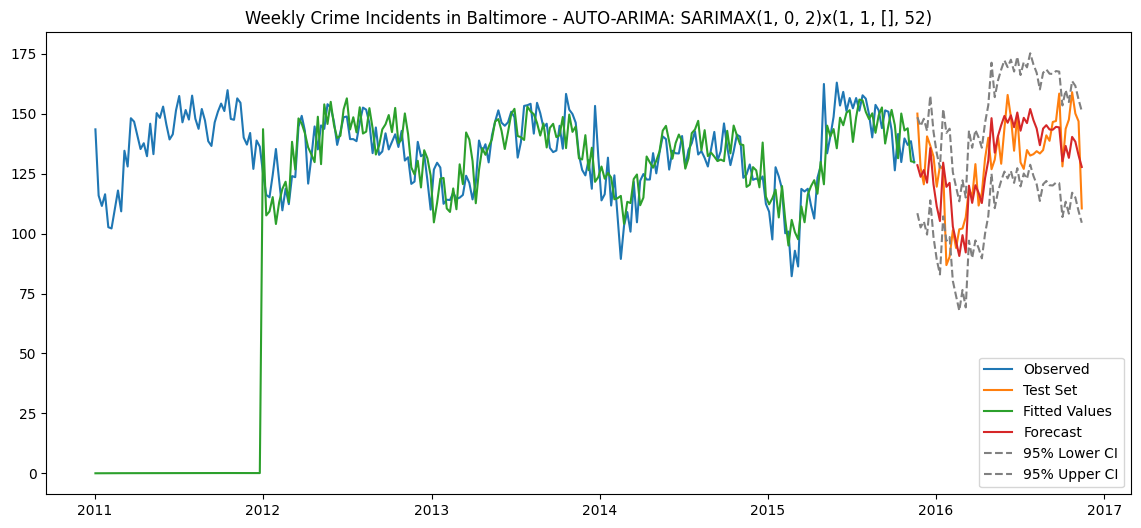

In [49]:
#plot the results using auto arima predictions
plt.figure(figsize=(14,6))
plt.plot(ts_train, label = 'Observed')
plt.plot(ts_test,label='Test Set')
plt.plot(aa_fitted_values,label='Fitted Values')
plt.plot(aa_predictions[0],label='Forecast')
plt.plot(ts_test.index,aa_predictions[1][:,0],label='95% Lower CI',color='grey',linestyle='--')
plt.plot(ts_test.index,aa_predictions[1][:,1],label='95% Upper CI',color='grey',linestyle='--')
plt.title(f'Weekly Crime Incidents in Baltimore - AUTO-ARIMA: SARIMAX(1, 0, 2)x(1, 1, [], 52)')
plt.legend(loc='lower right')

In [53]:
#calculate the mse between test set and AutoARIMA model and compare to manual SARIMA results
mse = mean_squared_error(ts_test,aa_predictions[0])
print(f'AutoARIMA MSE: {mse}')
print(f'SARIMA4 MSE: {sarima4[4]}')

AutoARIMA MSE: 160.45509500231313
SARIMA4 MSE: 126.8445562661154


AutoArima model has produced a lower MSE result and lower AIC suggesting the initial model is a better fit. This is likely due to differencing.